# Практическая работа 4. Наивный Байес

**Задача: "Определение категории электронных писем с использованием наивного
Байесовского классификатора и калибровка предсказанных вероятностей"**

**Описание задачи:** Решить задачу классификации электронных писем на категории (например,
спам или не спам) с использованием наивного Байесовского классификатора и провести
калибровку предсказанных вероятностей для улучшения надежности модели.

**1. Загрузка данных:**

Загрузить набор данных, содержащий электронные письма и их соответствующие метки
категорий. https://www.kaggle.com/datasets/ozlerhakan/spam-or-not-spam-dataset

In [1]:
!kaggle datasets download -d ozlerhakan/spam-or-not-spam-dataset
!unzip spam-or-not-spam-dataset.zip

Dataset URL: https://www.kaggle.com/datasets/ozlerhakan/spam-or-not-spam-dataset
License(s): other
  0% 0.00/1.16M [00:00<?, ?B/s]
100% 1.16M/1.16M [00:00<00:00, 36.3MB/s]
Archive:  spam-or-not-spam-dataset.zip
  inflating: spam_or_not_spam.csv    


In [2]:
import pandas as pd

data = pd.read_csv('spam_or_not_spam.csv')

In [3]:
data.head(5)

,email,label
0,date wed NUMBER aug NUMBER NUMBER NUMBER NUMB...,0
1,martin a posted tassos papadopoulos the greek ...,0
2,man threatens explosion in moscow thursday aug...,0
3,klez the virus that won t die already the most...,0
4,in adding cream to spaghetti carbonara which ...,0


In [4]:
len(data)

3000

In [5]:
from collections import Counter

Counter(data['label'])

Counter({0: 2500, 1: 500})

2. Предобработка текстовых данных:

In [6]:
data = data.dropna(subset=['email'])

In [7]:
len(data)

2999

Проверим аугментацию и разбиение 499 на 499

In [67]:
print((data['label'][:499] == 0).all(), (data['label'][-499:] ==1).all()) # 499 на 499

True True


In [47]:
import numpy as np

X = np.concatenate((data['email'][:499], data['email'][-499:]))
y = np.concatenate((data['label'][:499], data['label'][-499:]))

In [48]:
Counter(y)

Counter({0: 499, 1: 499})

Применим аугментацию

In [71]:
print((data['label'][:2500] == 0).all())

True


In [100]:
# 2500 данных с признаком 0

X_augmented = list(data['email'][:2500])
y_augmented = list(data['label'][:2500])

In [90]:
# !pip install nltk

In [101]:
import random
import nltk
from nltk.corpus import wordnet

nltk.download('wordnet')

# Функция для замены слов на синонимы
def replace_with_synonyms(text):
    words = text.split()
    augmented_words = []
    for word in words:
        # Получение синосетов для слова
        synonyms = wordnet.synsets(word)
        if synonyms:
            # Получение первого синонима из первого синосета
            synonym = synonyms[0].lemmas()[0].name()
            augmented_words.append(synonym)
        else:
            augmented_words.append(word)
    return ' '.join(augmented_words)

# Функция для вставки случайных слов
def insert_random_words(text, num_words=3):
    words = text.split()  # Разбиение текста на слова
    if len(words) <= num_words:
        return text  # Если слов меньше или равно num_words, вернуть исходный текст
    random_words = random.choices(words, k=num_words)  # Выбор случайных слов
    for word in random_words:
        random_index = random.randint(0, len(words))  # Выбор случайного индекса
        words.insert(random_index, word)  # Вставка слова в случайную позицию
    return ' '.join(words)  # Объединение слов обратно в строку

# Функция для удаления случайных слов
def delete_random_words(text, num_words=3):
    words = text.split()
    for _ in range(num_words):
        if words:
            random_index = random.randint(0, len(words) - 1)
            words.pop(random_index)
    return ' '.join(words)

# Функция для перестановки слов
def swap_words(text, num_swaps=3):
    words = text.split()
    for _ in range(num_swaps):
        if len(words) > 1:
            index1 = random.randint(0, len(words) - 1)
            index2 = random.randint(0, len(words) - 1)
            words[index1], words[index2] = words[index2], words[index1]
    return ' '.join(words)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Так как у нас по 500 спам писем, мы аугментацию применим по 5 раз нового текста

In [102]:
for i in data['email'][-499:]:
  [y_augmented.append(1) for _ in 'MIREA']
  X_augmented.append(i)
  X_augmented.append(replace_with_synonyms(i))
  X_augmented.append(insert_random_words(i))
  X_augmented.append(delete_random_words(i))
  X_augmented.append(swap_words(i))

In [105]:
Counter(y_augmented)

Counter({0: 2500, 1: 2495})

Теперь у нас есть 499 и 499 вырезанного текста и 2500 и 2495 аугментированного текста

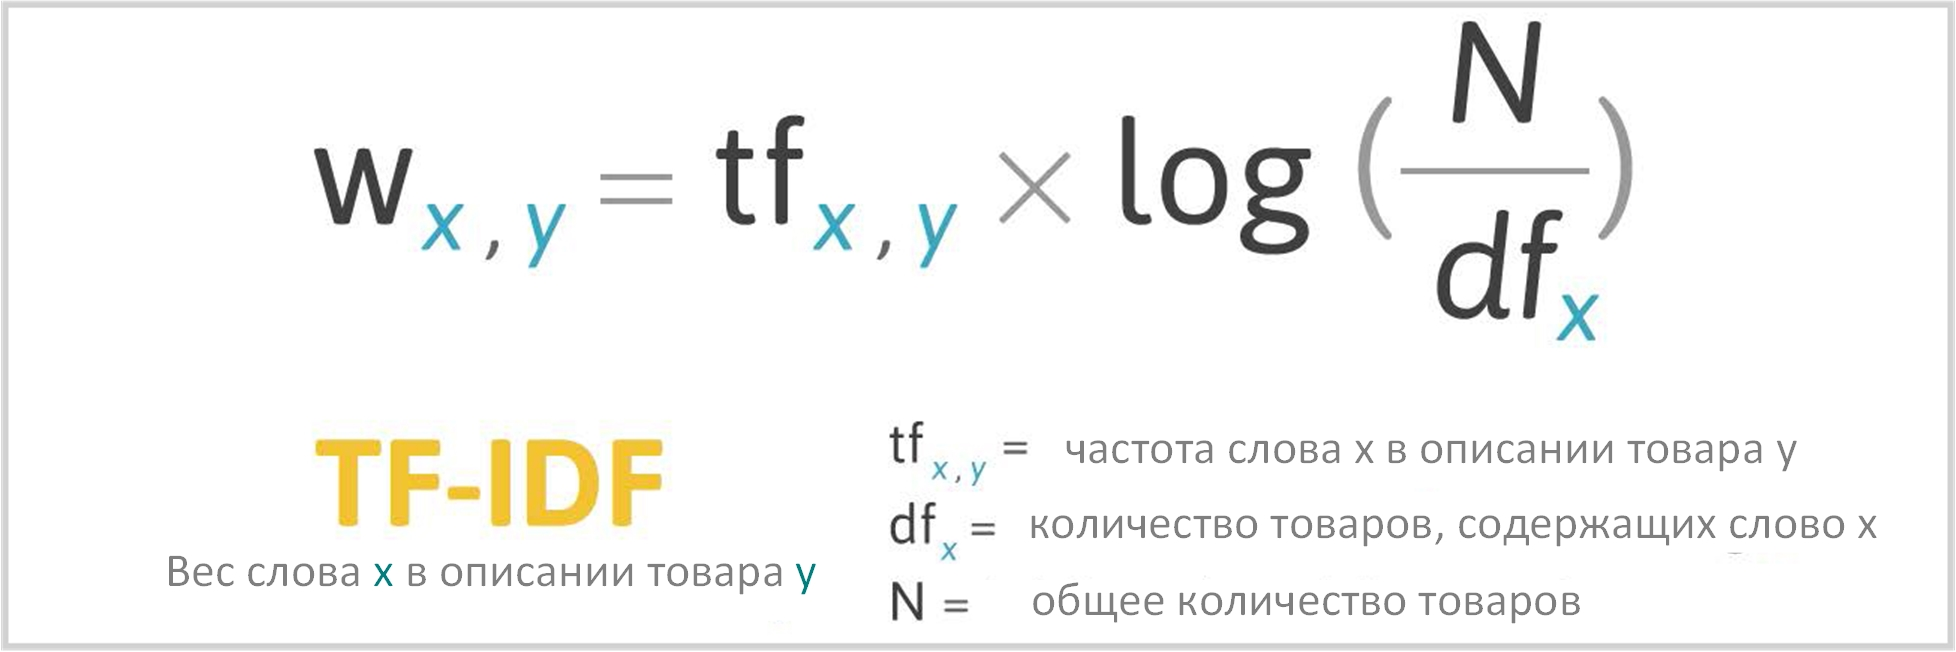

In [108]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()

X_cut = vectorizer.fit_transform(X)

X_augm = vectorizer.fit_transform(X_augmented)

**3. Тренировка наивного Байесовского классификатора:**

Реализация наивного Байесовского классификатора для определения категории
электронных писем.

MultinomialNB — это класс из библиотеки scikit-learn, который реализует мультиномиальный наивный байесовский классификатор. Этот алгоритм используется для классификации текстовых данных и других данных, которые можно представить в виде счетчиков (например, частот слов в документах).

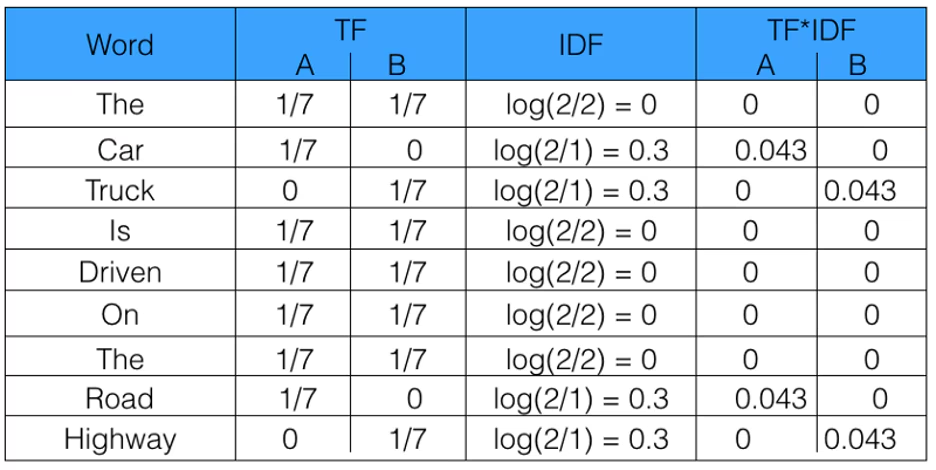

Наивный байес считает вероятность принадлежности к класу спам, с  условиями которые находятся внутри tfid и дает прогноз по табличкам выше

In [110]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, f1_score, recall_score, precision_score

X_train, X_test, y_train, y_test = train_test_split(X_cut, y, test_size=0.2, random_state=52)

X_train_aug, X_test_aug, y_train_aug, y_test_aug = train_test_split(X_augm, y_augmented, test_size=0.2, random_state=52)

nb_classifier = MultinomialNB()

nb_classifier.fit(X_train, y_train)

y_pred_cut = nb_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_cut)
report = classification_report(y_test, y_pred_cut)

print(f'Accuracy on cut data: {accuracy}')
print('Classification Report:')
print(report)

nb_classifier.fit(X_train_aug, y_train_aug)

y_pred_augmented = nb_classifier.predict(X_test_aug)

accuracy = accuracy_score(y_test_aug, y_pred_augmented)
report = classification_report(y_test_aug, y_pred_augmented)

print(f'Accuracy on augmented data: {accuracy}')
print('Classification Report:')
print(report)

Accuracy on cut data: 0.98
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       104
           1       0.98      0.98      0.98        96

    accuracy                           0.98       200
   macro avg       0.98      0.98      0.98       200
weighted avg       0.98      0.98      0.98       200

Accuracy on augmented data: 0.992992992992993
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       500
           1       1.00      0.99      0.99       499

    accuracy                           0.99       999
   macro avg       0.99      0.99      0.99       999
weighted avg       0.99      0.99      0.99       999



**4. Калибровка предсказанных вероятностей:**
Применение методов калибровки, таких как калибровка по платформе Платта или
изотоническая регрессия, для улучшения предсказанных вероятностей классов

**CalibratedClassifierCV:** Это класс из библиотеки scikit-learn, который используется для калибровки вероятностей, предсказанных классификатором. Калибровка помогает улучшить точность вероятностей, предсказанных моделью.

Методы калибровки:

sigmoid (Platt scaling): Использует логистическую регрессию для калибровки вероятностей.

isotonic: Использует изотоническую регрессию для калибровки вероятностей.


**Кривые калибровки (reliability curves):** Эти кривые показывают, насколько хорошо предсказанные вероятности соответствуют истинным вероятностям. Идеальная калибровка соответствует диагонали (идеально калиброванная модель).


**Brier score:** Это метрика, которая измеряет среднеквадратичное отклонение предсказанных вероятностей от истинных меток. Меньшее значение Brier score указывает на лучшую калибровку.

Изотоническая регрессия (Isotonic Regression) — это метод регрессии, который используется для монотонного приближения данных. Он предполагает, что функция, которую мы пытаемся приблизить, является монотонной, то есть она либо не убывает, либо не возрастает. Изотоническая регрессия часто используется для калибровки вероятностей в классификационных задачах, чтобы улучшить соответствие предсказанных вероятностей истинным вероятностям.

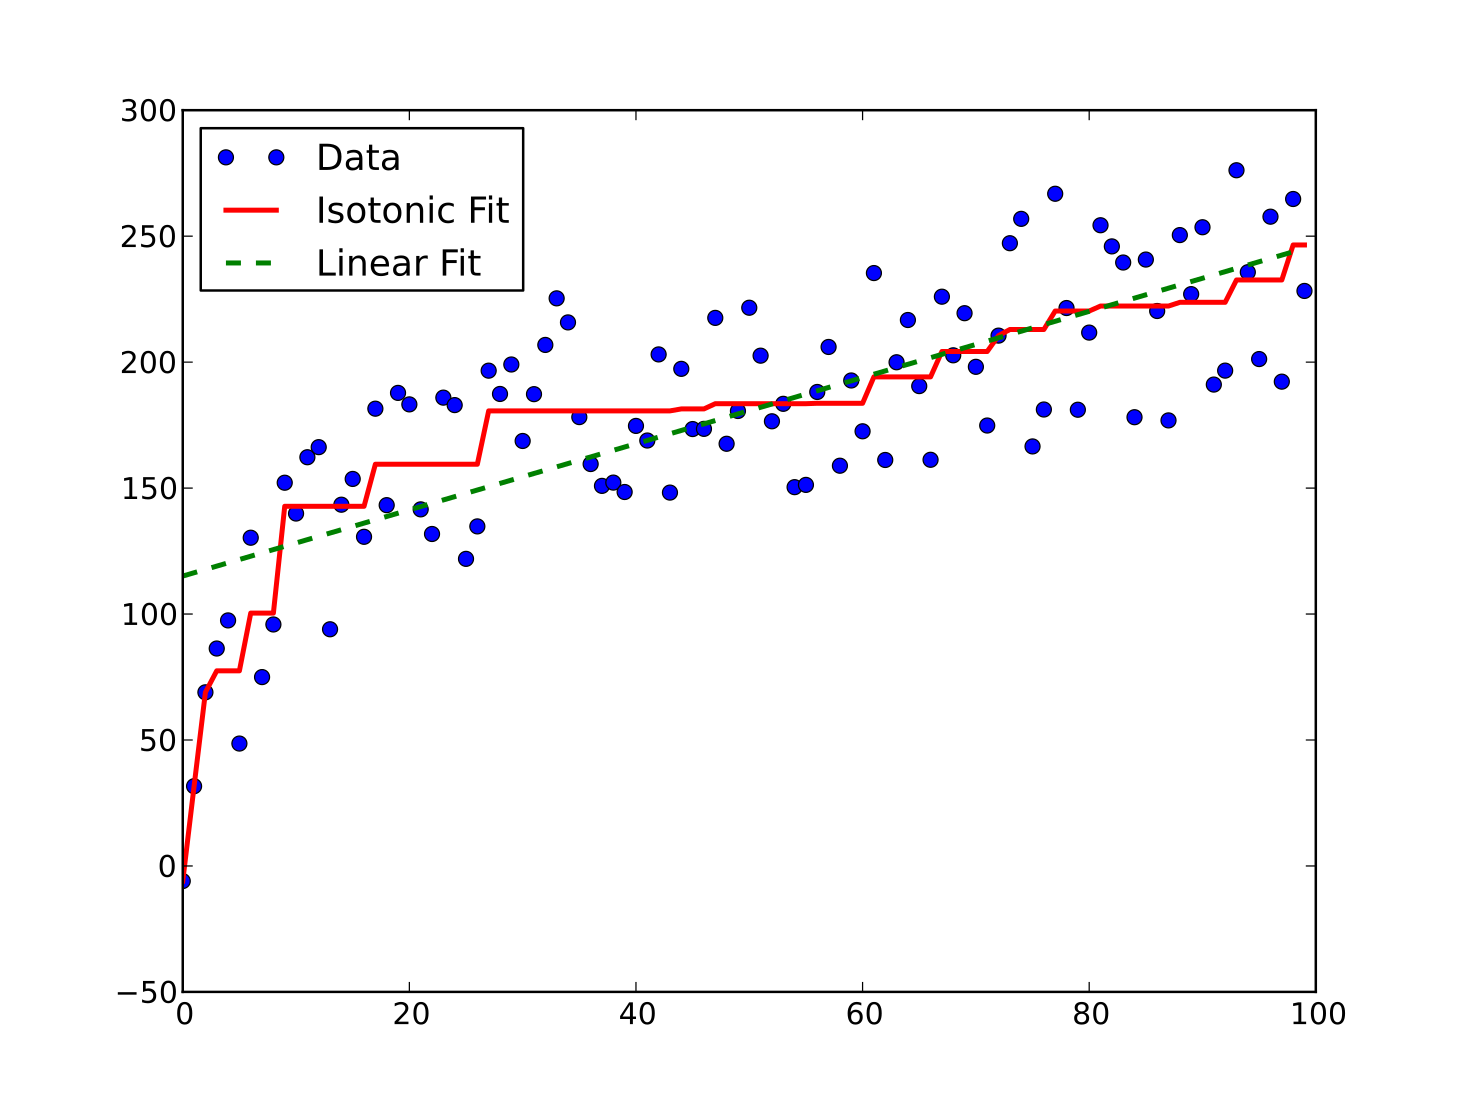

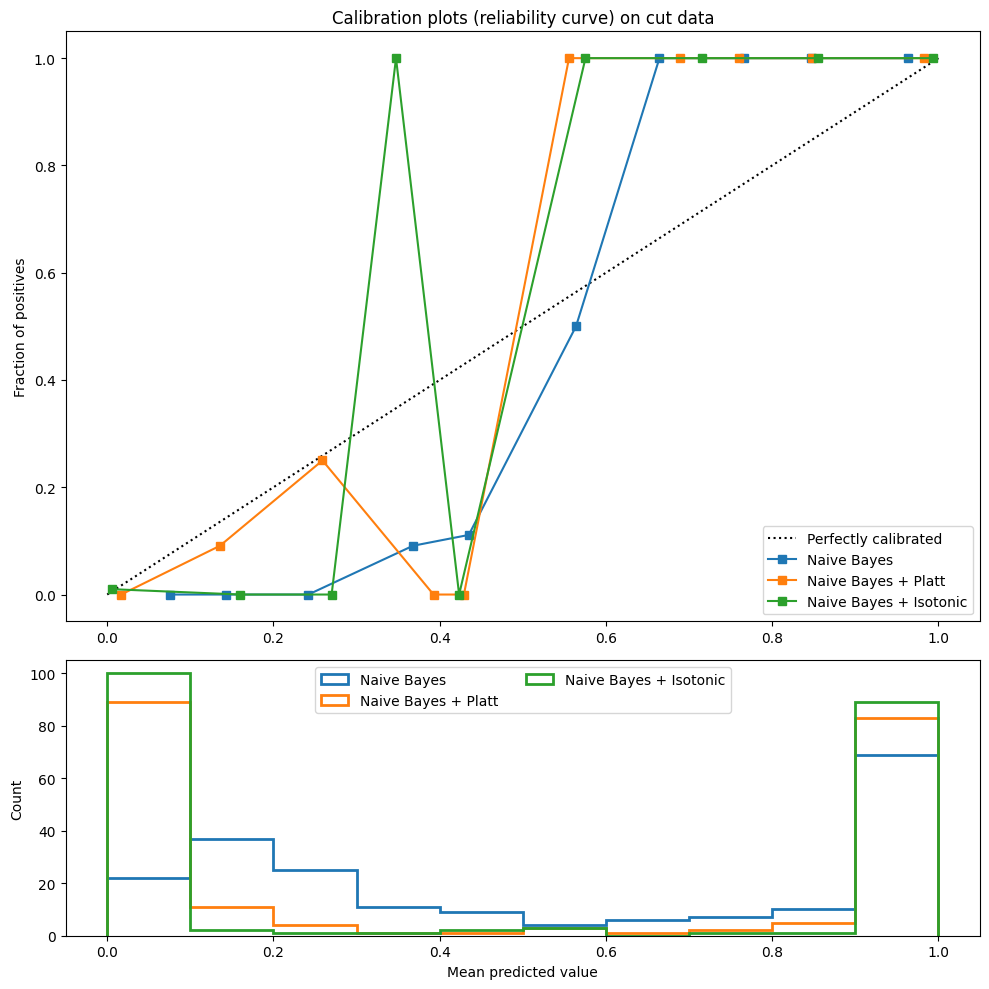

Brier score (Naive Bayes) on cut data: 0.041008045952115886
Brier score (Naive Bayes + Platt) on cut data: 0.015064192338352244
Brier score (Naive Bayes + Isotonic) on cut data: 0.012864822931715482
-----------------------------------------------------------
Accuracy (Naive Bayes) on cut data: 0.98
Accuracy (Naive Bayes + Platt) on cut data: 0.99
Accuracy (Naive Bayes + Isotonic) on cut data: 0.99


In [114]:
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import brier_score_loss, accuracy_score
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB

# Инициализация и обучение модели
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train, y_train)

# Предсказания вероятностей
y_prob = nb_classifier.predict_proba(X_test)[:, 1]

# Калибровка модели с методом Platt
calibrated_nb_platt = CalibratedClassifierCV(nb_classifier, method='sigmoid', cv=5)
calibrated_nb_platt.fit(X_train, y_train)
y_prob_calibrated_platt = calibrated_nb_platt.predict_proba(X_test)[:, 1]

# Калибровка модели с методом Isotonic
calibrated_nb_isotonic = CalibratedClassifierCV(nb_classifier, method='isotonic', cv=5)
calibrated_nb_isotonic.fit(X_train, y_train)
y_prob_calibrated_isotonic = calibrated_nb_isotonic.predict_proba(X_test)[:, 1]

# Построение кривых калибровки
plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))

ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10)
ax1.plot(prob_pred, prob_true, "s-", label="Naive Bayes")

prob_true, prob_pred = calibration_curve(y_test, y_prob_calibrated_platt, n_bins=10)
ax1.plot(prob_pred, prob_true, "s-", label="Naive Bayes + Platt")

prob_true, prob_pred = calibration_curve(y_test, y_prob_calibrated_isotonic, n_bins=10)
ax1.plot(prob_pred, prob_true, "s-", label="Naive Bayes + Isotonic")

ax2.hist(y_prob, range=(0, 1), bins=10, label="Naive Bayes", histtype="step", lw=2)
ax2.hist(y_prob_calibrated_platt, range=(0, 1), bins=10, label="Naive Bayes + Platt", histtype="step", lw=2)
ax2.hist(y_prob_calibrated_isotonic, range=(0, 1), bins=10, label="Naive Bayes + Isotonic", histtype="step", lw=2)

ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('Calibration plots (reliability curve) on cut data')

ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)

plt.tight_layout()
plt.show()

# Вычисление Brier score
print(f"Brier score (Naive Bayes) on cut data: {brier_score_loss(y_test, y_prob)}")
print(f"Brier score (Naive Bayes + Platt) on cut data: {brier_score_loss(y_test, y_prob_calibrated_platt)}")
print(f"Brier score (Naive Bayes + Isotonic) on cut data: {brier_score_loss(y_test, y_prob_calibrated_isotonic)}")

# Вычисление точности
y_pred = nb_classifier.predict(X_test)
accuracy_nb = accuracy_score(y_test, y_pred)

y_pred_calibrated_platt = calibrated_nb_platt.predict(X_test)
accuracy_calibrated_platt = accuracy_score(y_test, y_pred_calibrated_platt)

y_pred_calibrated_isotonic = calibrated_nb_isotonic.predict(X_test)
accuracy_calibrated_isotonic = accuracy_score(y_test, y_pred_calibrated_isotonic)

print('-----------------------------------------------------------')
print(f"Accuracy (Naive Bayes) on cut data: {accuracy_nb}")
print(f"Accuracy (Naive Bayes + Platt) on cut data: {accuracy_calibrated_platt}")
print(f"Accuracy (Naive Bayes + Isotonic) on cut data: {accuracy_calibrated_isotonic}")

Применим тот же алгоритм для Augmented data

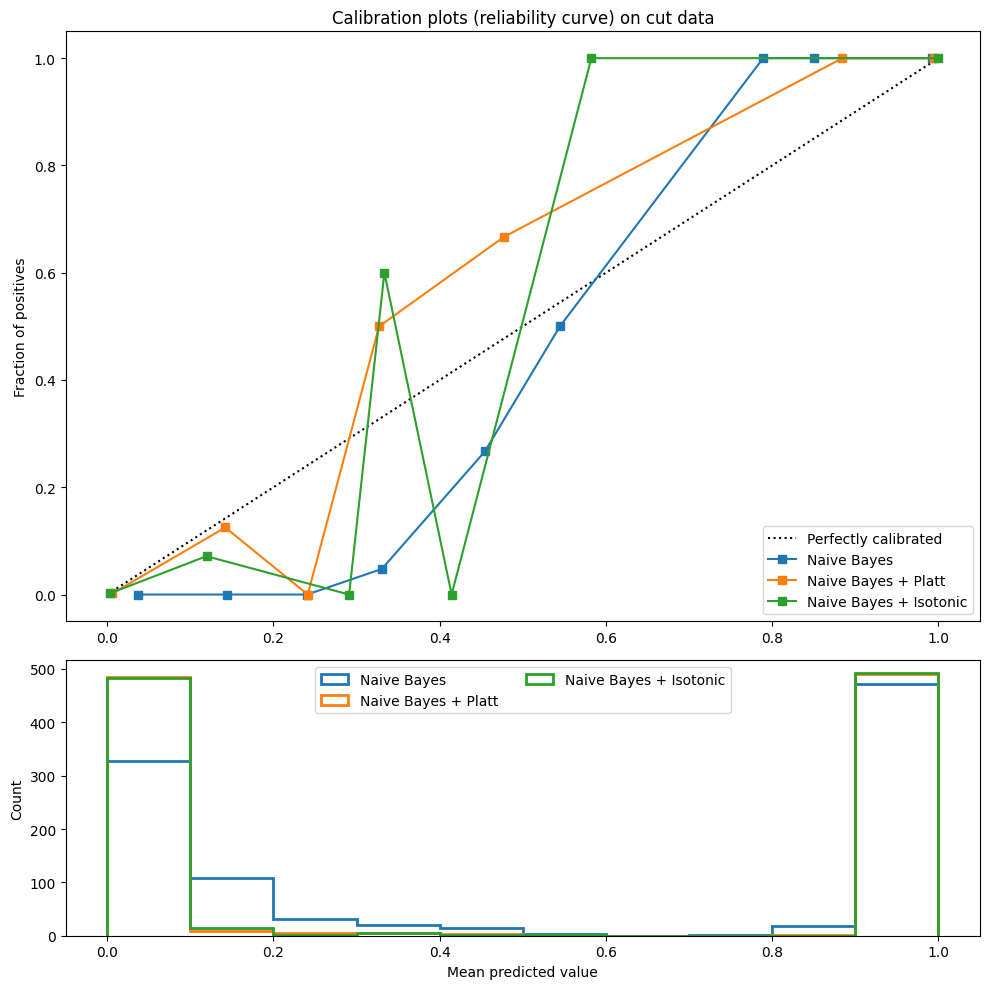

Brier score (Naive Bayes) on cut data: 0.01240423448113613
Brier score (Naive Bayes + Platt) on cut data: 0.0047816160227991495
Brier score (Naive Bayes + Isotonic) on cut data: 0.004284928333526881
-----------------------------------------------------------
Accuracy (Naive Bayes) on cut data: 0.992992992992993
Accuracy (Naive Bayes + Platt) on cut data: 0.992992992992993
Accuracy (Naive Bayes + Isotonic) on cut data: 0.994994994994995


In [115]:
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import brier_score_loss, accuracy_score
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB

# Инициализация и обучение модели
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_aug, y_train_aug)

# Предсказания вероятностей
y_prob = nb_classifier.predict_proba(X_test_aug)[:, 1]

# Калибровка модели с методом Platt
calibrated_nb_platt = CalibratedClassifierCV(nb_classifier, method='sigmoid', cv=5)
calibrated_nb_platt.fit(X_train_aug, y_train_aug)
y_prob_calibrated_platt = calibrated_nb_platt.predict_proba(X_test_aug)[:, 1]

# Калибровка модели с методом Isotonic
calibrated_nb_isotonic = CalibratedClassifierCV(nb_classifier, method='isotonic', cv=5)
calibrated_nb_isotonic.fit(X_train_aug, y_train_aug)
y_prob_calibrated_isotonic = calibrated_nb_isotonic.predict_proba(X_test_aug)[:, 1]

# Построение кривых калибровки
plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))

ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

prob_true, prob_pred = calibration_curve(y_test_aug, y_prob, n_bins=10)
ax1.plot(prob_pred, prob_true, "s-", label="Naive Bayes")

prob_true, prob_pred = calibration_curve(y_test_aug, y_prob_calibrated_platt, n_bins=10)
ax1.plot(prob_pred, prob_true, "s-", label="Naive Bayes + Platt")

prob_true, prob_pred = calibration_curve(y_test_aug, y_prob_calibrated_isotonic, n_bins=10)
ax1.plot(prob_pred, prob_true, "s-", label="Naive Bayes + Isotonic")

ax2.hist(y_prob, range=(0, 1), bins=10, label="Naive Bayes", histtype="step", lw=2)
ax2.hist(y_prob_calibrated_platt, range=(0, 1), bins=10, label="Naive Bayes + Platt", histtype="step", lw=2)
ax2.hist(y_prob_calibrated_isotonic, range=(0, 1), bins=10, label="Naive Bayes + Isotonic", histtype="step", lw=2)

ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('Calibration plots (reliability curve) on cut data')

ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)

plt.tight_layout()
plt.show()

# Вычисление Brier score
print(f"Brier score (Naive Bayes) on cut data: {brier_score_loss(y_test_aug, y_prob)}")
print(f"Brier score (Naive Bayes + Platt) on cut data: {brier_score_loss(y_test_aug, y_prob_calibrated_platt)}")
print(f"Brier score (Naive Bayes + Isotonic) on cut data: {brier_score_loss(y_test_aug, y_prob_calibrated_isotonic)}")

# Вычисление точности
y_pred = nb_classifier.predict(X_test_aug)
accuracy_nb = accuracy_score(y_test_aug, y_pred)

y_pred_calibrated_platt = calibrated_nb_platt.predict(X_test_aug)
accuracy_calibrated_platt = accuracy_score(y_test_aug, y_pred_calibrated_platt)

y_pred_calibrated_isotonic = calibrated_nb_isotonic.predict(X_test_aug)
accuracy_calibrated_isotonic = accuracy_score(y_test_aug, y_pred_calibrated_isotonic)

print('-----------------------------------------------------------')
print(f"Accuracy (Naive Bayes) on cut data: {accuracy_nb}")
print(f"Accuracy (Naive Bayes + Platt) on cut data: {accuracy_calibrated_platt}")
print(f"Accuracy (Naive Bayes + Isotonic) on cut data: {accuracy_calibrated_isotonic}")